In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
# VisualWarehouse env
class VisualWarehouse:
    def __init__(self, height=6, width=6, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.H = height
        self.W = width
        self.grid = np.zeros((self.H, self.W), dtype=int)

        # fixed obstacles
        obstacles = [(1,2), (2,2), (3,2), (4,3)]
        for (r,c) in obstacles:
            self.grid[r,c] = 1

        # pickup, drop, robot start (robot will start at a random free cell not pickup/drop)
        self.pickup = (0, 0)
        self.drop = (5, 5)
        free_cells = [(r,c) for r in range(self.H) for c in range(self.W)
                      if self.grid[r,c] == 0 and (r,c) not in [self.pickup, self.drop]]
        # deterministic random start for reproducibility
        self.robot = free_cells[ ( (seed or 7) ) % len(free_cells) ]
        self.carrying = False

        self.grid[self.pickup] = 2
        self.grid[self.drop] = 3

    def move_toward(self, target):
        r, c = self.robot
        tr, tc = target
        moves = []
        if r < tr: moves.append((r+1, c))
        if r > tr: moves.append((r-1, c))
        if c < tc: moves.append((r, c+1))
        if c > tc: moves.append((r, c-1))
        valid_moves = [m for m in moves if 0<=m[0]<self.H and 0<=m[1]<self.W and self.grid[m]!=1]
        if valid_moves:
            self.robot = valid_moves[0]

    def step_rule(self):
        # same simple greedy rule used in prototype (for initial demo)
        target = self.pickup if not self.carrying else self.drop
        self.move_toward(target)
        # pickup/drop detection
        if self.robot == self.pickup and not self.carrying:
            self.carrying = True
            print("📦 Picked up the item!")
        elif self.robot == self.drop and self.carrying:
            self.carrying = False
            print("🎯 Dropped the item! Task completed.")
            return True
        return False

    def render(self, title=""):
        vis = np.ones((self.H, self.W, 3))
        for r in range(self.H):
            for c in range(self.W):
                if self.grid[r,c] == 1:
                    vis[r,c] = [0.5,0.5,0.5]  # gray obstacles
                elif (r,c) == self.pickup:
                    vis[r,c] = [0,1,0]        # green pickup
                elif (r,c) == self.drop:
                    vis[r,c] = [1,0,0]        # red drop
        rr, cc = self.robot
        vis[rr, cc] = [0,0,1] if self.carrying else [0.3,0.3,1]  # blue robot
        plt.imshow(vis)
        plt.title(title, fontsize=12)
        plt.xticks([]); plt.yticks([])
        plt.grid(False)
        plt.pause(0.45)
        plt.clf()


Robot starting at: (2, 0)
Pickup at: (0, 0) | Drop at: (5, 5)
Moving to pickup...


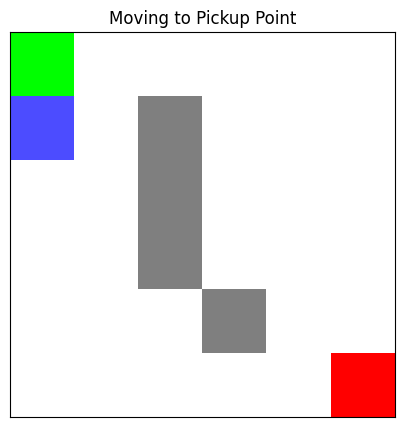

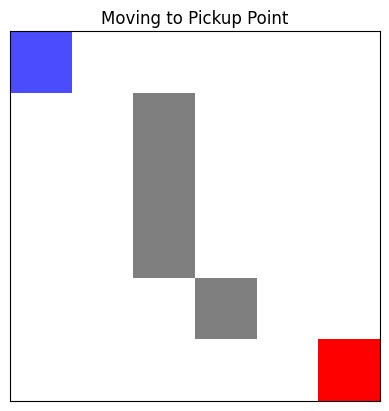

/tmp/ipython-input-1627954028.py:69: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.pause(0.45)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


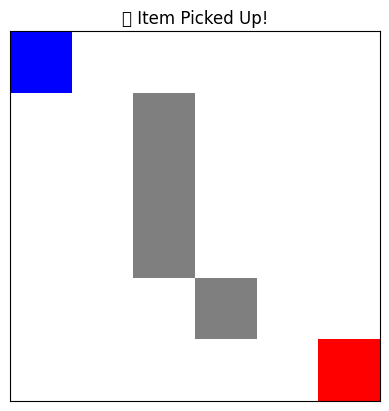

📦 Picked up the item!
Delivering to drop point...


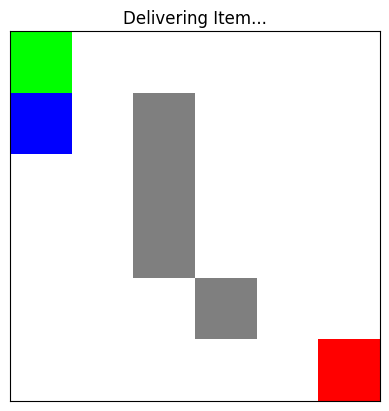

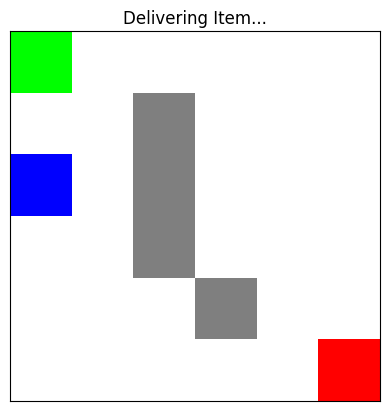

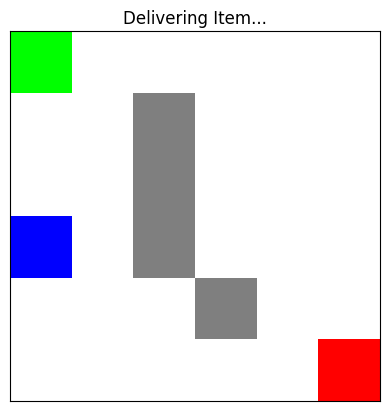

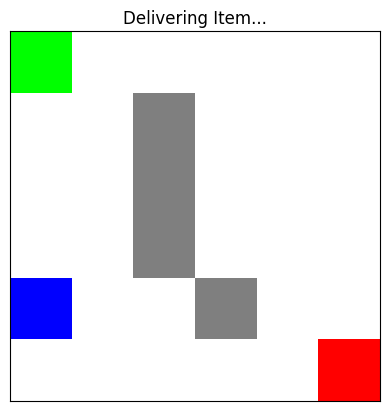

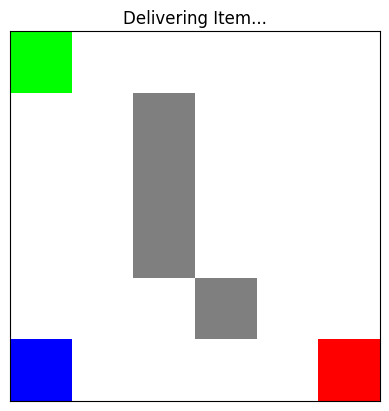

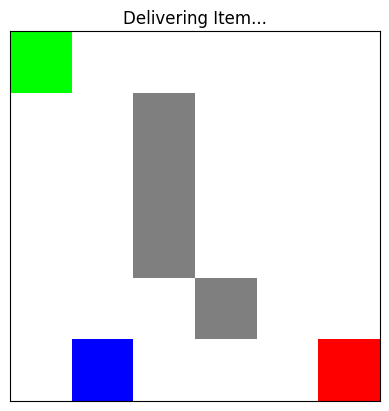

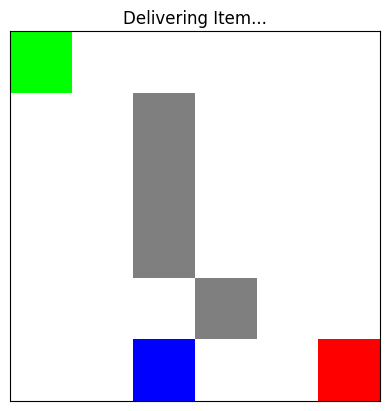

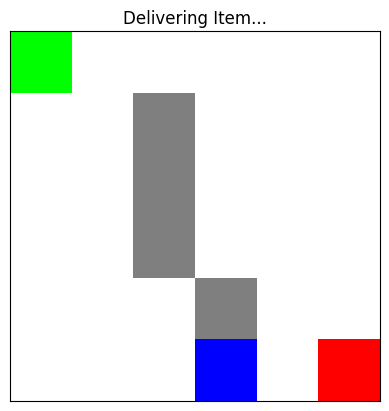

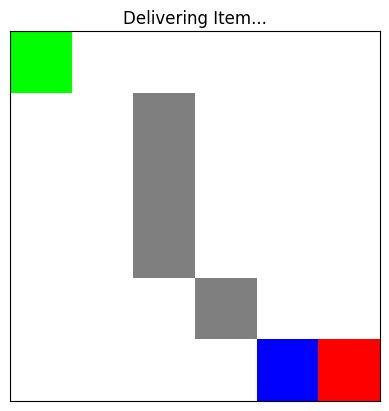

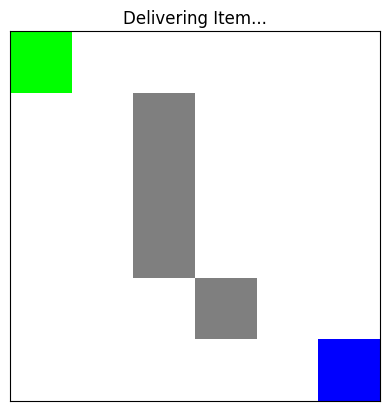

/tmp/ipython-input-1627954028.py:69: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.pause(0.45)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


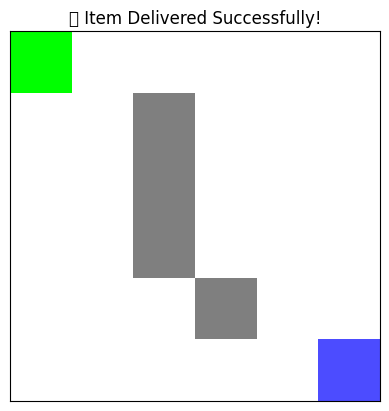

🎯 Dropped the item! Task completed.


In [3]:
# Run the EXACT prototype behavior
env_demo = VisualWarehouse(seed=10)   # pick a seed so the robot start is visible and reproducible
plt.figure(figsize=(5,5))

print("Robot starting at:", env_demo.robot)
print("Pickup at:", env_demo.pickup, "| Drop at:", env_demo.drop)
print("Moving to pickup...")

# Move to pickup
while env_demo.robot != env_demo.pickup:
    env_demo.move_toward(env_demo.pickup)
    env_demo.render("Moving to Pickup Point")
# pickup
env_demo.carrying = True
env_demo.render("📦 Item Picked Up!")
print("📦 Picked up the item!")
time.sleep(0.8)

# Move to drop
print("Delivering to drop point...")
while env_demo.robot != env_demo.drop:
    env_demo.move_toward(env_demo.drop)
    env_demo.render("Delivering Item...")
# drop
env_demo.carrying = False
env_demo.render("🎯 Item Delivered Successfully!")
print("🎯 Dropped the item! Task completed.")
plt.close()


In [4]:
# Gym-like wrapper (lightweight) for RL training
class RLWarehouse:
    def __init__(self, height=6, width=6, seed=None):
        self.H = height; self.W = width
        self.seed = seed
        self.reset()

    def reset(self):
        self.env = VisualWarehouse(height=self.H, width=self.W, seed=self.seed)
        # state as vector floats in [0,1]
        return self._get_state()

    def _get_state(self):
        rr, rc = self.env.robot
        pr, pc = self.env.pickup
        dr, dc = self.env.drop
        car = 1.0 if self.env.carrying else 0.0
        # normalize by (H-1)/(W-1)
        s = np.array([rr/(self.H-1), rc/(self.W-1),
                      pr/(self.H-1), pc/(self.W-1),
                      dr/(self.H-1), dc/(self.W-1),
                      car], dtype=np.float32)
        return s

    def step(self, action):
        # actions: 0=up,1=down,2=left,3=right,4=stay/pick-drop
        r, c = self.env.robot
        reward = -1.0  # step penalty
        done = False
        if action == 0:
            nr, nc = r-1, c
        elif action == 1:
            nr, nc = r+1, c
        elif action == 2:
            nr, nc = r, c-1
        elif action == 3:
            nr, nc = r, c+1
        elif action == 4:
            nr, nc = r, c
            # pick/drop
            if (nr, nc) == self.env.pickup and not self.env.carrying:
                self.env.carrying = True
                reward += 5.0  # bonus for picking
            elif (nr, nc) == self.env.drop and self.env.carrying:
                self.env.carrying = False
                reward += 20.0
                done = True
            else:
                reward -= 2.0  # invalid pick/drop
        # movement: check bounds/obstacle
        if action in [0,1,2,3]:
            if 0 <= nr < self.H and 0 <= nc < self.W and self.env.grid[nr,nc] != 1:
                self.env.robot = (nr, nc)
            else:
                reward -= 5.0  # penalty for bumping into obstacle / wall

        return self._get_state(), reward, done, {}

    def render(self, title=""):
        self.env.render(title)


In [5]:
# DQN implementation (lightweight)
Transition = namedtuple('Transition', ('state','action','reward','next_state','done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

class QNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim=7, action_dim=5, device='cpu'):
        self.device = torch.device(device)
        self.q = QNet(state_dim, action_dim).to(self.device)
        self.target = QNet(state_dim, action_dim).to(self.device)
        self.target.load_state_dict(self.q.state_dict())
        self.opt = optim.Adam(self.q.parameters(), lr=1e-3)
        self.replay = ReplayBuffer(5000)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 200
        self.steps = 0
        self.loss_fn = nn.MSELoss()

    def act(self, state, eps=0.1):
        if random.random() < eps:
            return random.randrange(5)
        s = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            qvals = self.q(s)
        return int(qvals.argmax().item())

    def store(self, s,a,r,ns,d):
        self.replay.push(s,a,r,ns,d)

    def train_step(self):
        if len(self.replay) < 200:
            return None
        batch = self.replay.sample(self.batch_size)
        s = torch.FloatTensor(np.array(batch.state)).to(self.device)
        a = torch.LongTensor(batch.action).unsqueeze(1).to(self.device)
        r = torch.FloatTensor(batch.reward).unsqueeze(1).to(self.device)
        ns = torch.FloatTensor(np.array(batch.next_state)).to(self.device)
        d = torch.FloatTensor(np.array(batch.done).astype(np.float32)).unsqueeze(1).to(self.device)

        q_vals = self.q(s).gather(1,a)
        with torch.no_grad():
            next_q = self.target(ns).max(1)[0].unsqueeze(1)
            target_q = r + (1-d)*self.gamma*next_q

        loss = self.loss_fn(q_vals, target_q)
        self.opt.zero_grad(); loss.backward(); self.opt.step()

        self.steps += 1
        if self.steps % self.update_target_every == 0:
            self.target.load_state_dict(self.q.state_dict())
        return loss.item()


Ep 20/200 avg_last20=-460.10 eps=0.90
Ep 40/200 avg_last20=-378.60 eps=0.82
Ep 60/200 avg_last20=-201.20 eps=0.74
Ep 80/200 avg_last20=-92.60 eps=0.67
Ep 100/200 avg_last20=-75.45 eps=0.61
Ep 120/200 avg_last20=-43.90 eps=0.55
Ep 140/200 avg_last20=-39.75 eps=0.50
Ep 160/200 avg_last20=-27.00 eps=0.45
Ep 180/200 avg_last20=-21.15 eps=0.41
Ep 200/200 avg_last20=-19.60 eps=0.37


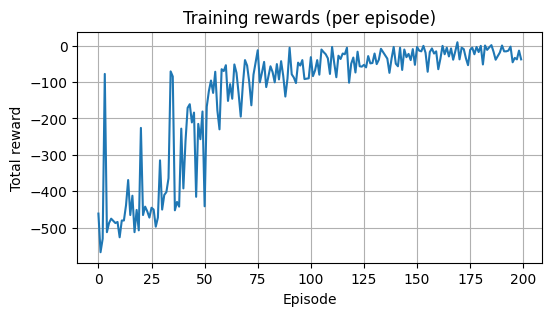

In [6]:
# Train DQN (short demo)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent = DQNAgent(state_dim=7, action_dim=5, device=device)
env_rl = RLWarehouse()

episodes = 200   # CHANGE to 1000+ for better policy
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.995

all_rewards = []
for ep in range(1, episodes+1):
    state = env_rl.reset()
    total_r = 0.0
    done = False
    eps = max(eps_end, eps_start * (eps_decay ** ep))
    steps = 0
    while not done and steps < 200:
        action = agent.act(state, eps)
        next_state, reward, done, _ = env_rl.step(action)
        agent.store(state, action, reward, next_state, done)
        agent.train_step()
        state = next_state
        total_r += reward
        steps += 1
    all_rewards.append(total_r)
    if ep % 20 == 0:
        print(f"Ep {ep}/{episodes} avg_last20={np.mean(all_rewards[-20:]):.2f} eps={eps:.2f}")

# Quick plot of training rewards
plt.figure(figsize=(6,3))
plt.plot(all_rewards)
plt.title("Training rewards (per episode)")
plt.xlabel("Episode"); plt.ylabel("Total reward")
plt.grid(True)
plt.show()


Starting evaluation rollout...


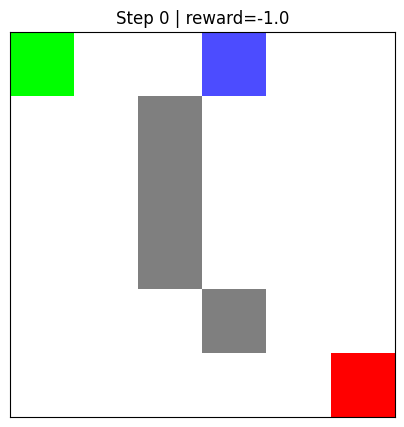

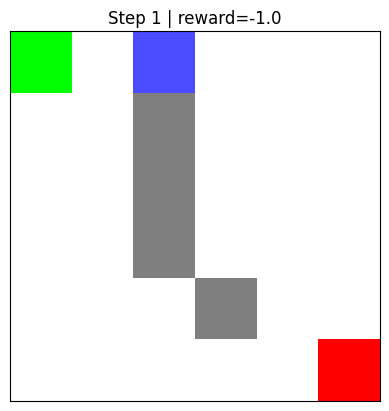

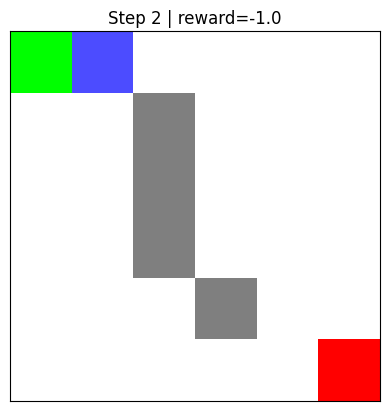

Picked up the item!


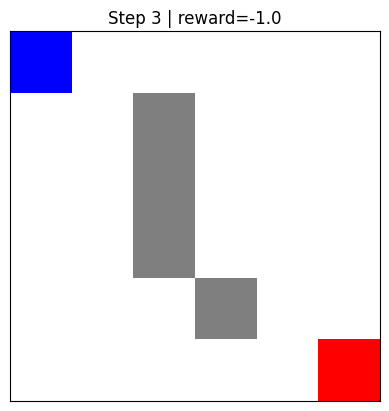

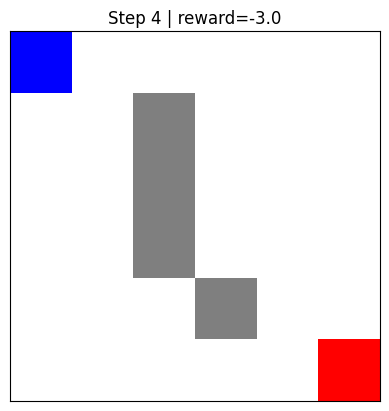

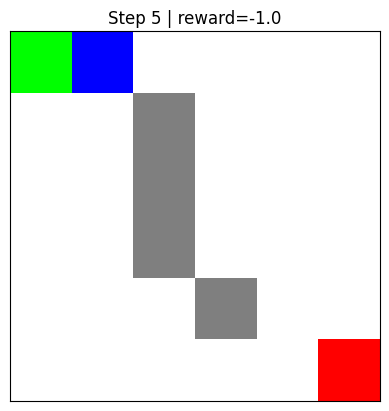

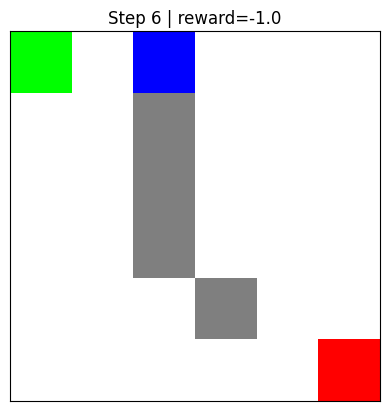

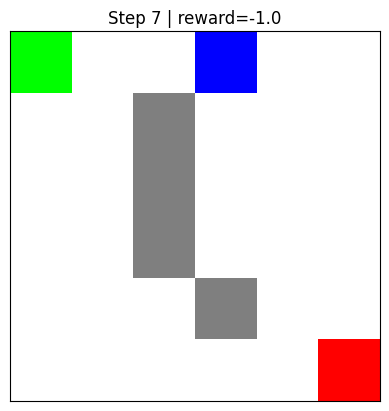

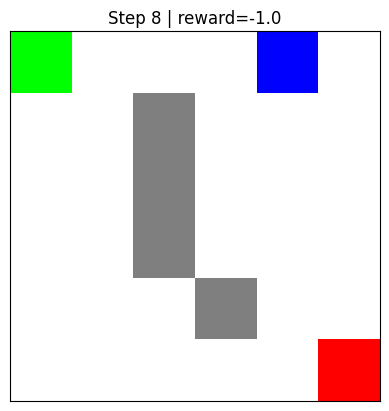

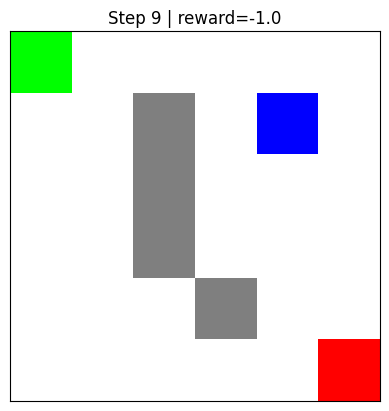

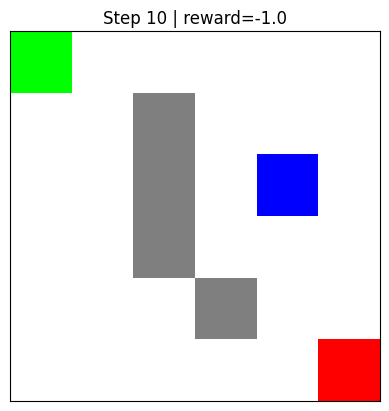

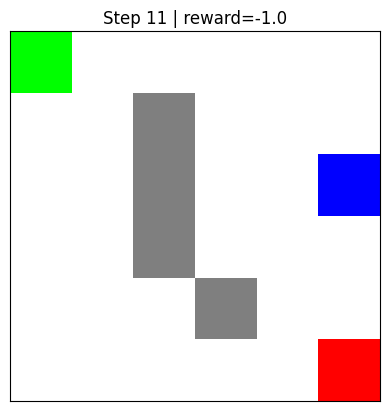

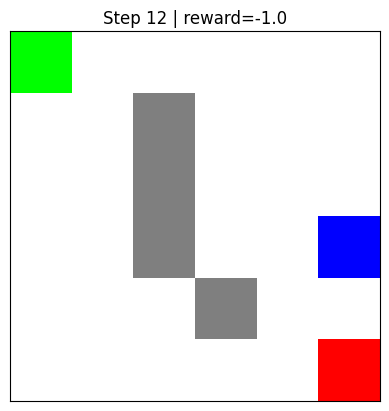

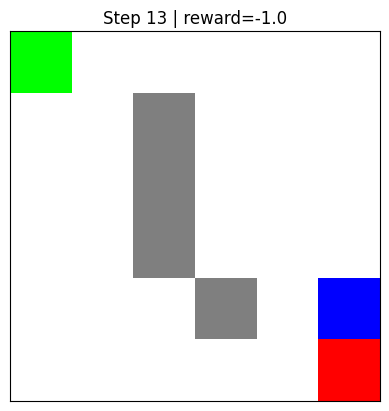

Delivered the item! ✅


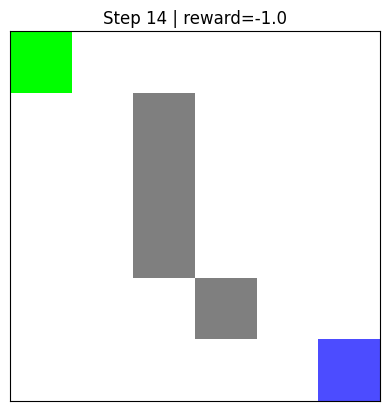

Evaluation finished. Total steps: 15


In [8]:
# Evaluate learned policy and animate rollout
import matplotlib.pyplot as plt
import time

env_eval = RLWarehouse()
state = env_eval.reset()
plt.figure(figsize=(5,5))
done = False
step = 0
picked = False
delivered = False
print("Starting evaluation rollout...")

def render_visual(env, title=""):
    """Visual rendering matching previous prototype style."""
    vis = np.ones((env.H, env.W, 3))
    for r in range(env.H):
        for c in range(env.W):
            if env.grid[r, c] == 1:
                vis[r, c] = [0.5, 0.5, 0.5]  # gray obstacle
            elif (r, c) == env.pickup:
                vis[r, c] = [0, 1, 0]        # green pickup
            elif (r, c) == env.drop:
                vis[r, c] = [1, 0, 0]        # red drop

    rr, cc = env.robot
    vis[rr, cc] = [0, 0, 1] if env.carrying else [0.3, 0.3, 1]  # robot color
    plt.imshow(vis)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.grid(False)
    plt.pause(0.4)
    plt.clf()

while not done and step < 200:
    # Choose greedy action from trained DQN
    action = agent.act(state, eps=0.0)
    next_state, reward, done, _ = env_eval.step(action)
    state = next_state

    # Detect pickup/drop events
    if hasattr(env_eval, 'env'):
        robot_pos = env_eval.env.robot
        pickup_pos = env_eval.env.pickup
        drop_pos = env_eval.env.drop
    else:
        robot_pos = env_eval.robot
        pickup_pos = env_eval.pickup
        drop_pos = env_eval.drop

    # Pickup item
    if robot_pos == pickup_pos and not picked:
        picked = True
        if hasattr(env_eval, 'env'):
            env_eval.env.carrying = True
        else:
            env_eval.carrying = True
        print("Picked up the item!")

    # Deliver item
    elif robot_pos == drop_pos and picked and not delivered:
        delivered = True
        if hasattr(env_eval, 'env'):
            env_eval.env.carrying = False
        else:
            env_eval.carrying = False
        print("Delivered the item! ✅")
        done = True  # ✅ End rollout immediately after delivery

    # Render identical visuals
    render_visual(env_eval.env if hasattr(env_eval, 'env') else env_eval,
                  title=f"Step {step} | reward={reward:.1f}")
    step += 1

plt.close()
print("Evaluation finished. Total steps:", step)
